In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import os
from transformers import BertModel

In [2]:
import csv
train_df = pd.read_csv('/kaggle/input/aes-dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/aes-dataset/test.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [4]:
# Pre-trained BERT model variant
model_name = 'bert-base-uncased'

# Loading the pre-trained BERT model
bert_model = BertModel.from_pretrained(model_name)

# Loading the corresponding tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# Maximum sequence length for BERT
max_length = 512

# Preprocessing text data
def preprocess_text(text, tokenizer, max_length):
    # Tokenize the text
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Extract input_ids tensor
    input_ids = tokenized_text['input_ids']

    return input_ids

# Filter out rows with missing values in the 'full_text' column
train_df = train_df.dropna(subset=['full_text'])

# Preprocess the 'full_text' column
train_df['tokenized_text'] = train_df['full_text'].apply(lambda x: preprocess_text(x, tokenizer, max_length))
     

In [6]:
train_df.head()

,essay_id,full_text,score,tokenized_text
0,000d118,Many people have car where they live. The thin...,3,"[[tensor(101), tensor(2116), tensor(2111), ten..."
1,000fe60,I am a scientist at NASA that is discussing th...,3,"[[tensor(101), tensor(1045), tensor(2572), ten..."
2,001ab80,People always wish they had the same technolog...,4,"[[tensor(101), tensor(2111), tensor(2467), ten..."
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[[tensor(101), tensor(2057), tensor(2035), ten..."
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[[tensor(101), tensor(6203), tensor(1010), ten..."


In [7]:
class BertRegressionModel(nn.Module):
    def __init__(self, pretrained_bert_model, num_regression_features):
        super(BertRegressionModel, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_bert_model)
        self.regression_head = nn.Linear(self.bert.config.hidden_size, num_regression_features)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        regression_output = self.regression_head(pooled_output)
        return regression_output

# In our project
pretrained_bert_model = 'bert-base-uncased'
num_regression_features = 1

# Initialize the regression model
model = BertRegressionModel(pretrained_bert_model, num_regression_features)

# Print the model architecture
print(model)

BertRegressionModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

Starting epoch 1/10
Epoch 1/10, Loss: 0.5677005270988356
Starting epoch 2/10
Epoch 2/10, Loss: 0.36286335789672547
Starting epoch 3/10
Epoch 3/10, Loss: 0.31267634199419214
Starting epoch 4/10
Epoch 4/10, Loss: 0.2528306977365462
Starting epoch 5/10
Epoch 5/10, Loss: 0.19583272011244804
Starting epoch 6/10
Epoch 6/10, Loss: 0.1459668935956554
Starting epoch 7/10
Epoch 7/10, Loss: 0.10121097571307762
Starting epoch 8/10
Epoch 8/10, Loss: 0.07872725412414827
Starting epoch 9/10
Epoch 9/10, Loss: 0.06120048034006589
Starting epoch 10/10
Epoch 10/10, Loss: 0.05209953083816826


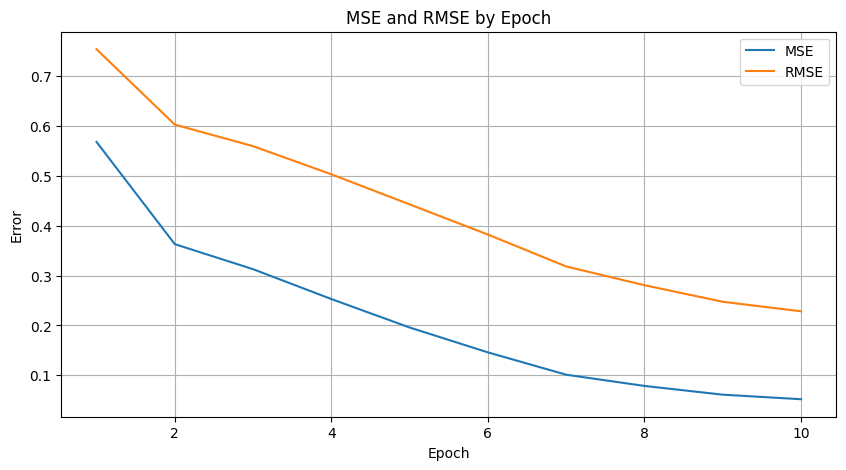

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length for BERT
max_length = 512

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['full_text']
        inputs = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        target_cols = ['score']
        targets = [float(self.data.iloc[idx].get(col, float('nan'))) for col in target_cols]

        targets = torch.tensor(targets, dtype=torch.float)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'targets': targets
        }

train_df = pd.read_csv('/kaggle/input/aes-dataset/train.csv')
train_dataset = CustomDataset(train_df, tokenizer, max_length)

# Define hyperparameters
batch_size = 32
num_epochs = 10
# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class BertRegressionModel(nn.Module):
    def __init__(self):
        super(BertRegressionModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.regression_head = nn.Linear(self.bert.config.hidden_size,1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        regression_output = self.regression_head(pooled_output)
        return regression_output

model = BertRegressionModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

mse = []
rmse = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    print(f'Starting epoch {epoch+1}/{num_epochs}')
    batch_count = 0
    for batch in train_dataloader:
        batch_count += 1
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        targets = batch['targets']

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    mse.append(average_loss)
    rmse.append(np.sqrt(average_loss))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}')

# Plotting MSE and RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), mse, label='MSE')
plt.plot(range(1, num_epochs+1), rmse, label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('MSE and RMSE by Epoch')
plt.legend()
plt.grid(True)

plt.show()

In [9]:
 valid_df= pd.read_csv('/kaggle/input/valid-data/sample_submission.csv')

In [10]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length for BERT
max_length = 512

class CustomTestDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['full_text']
        inputs = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze(0).to(device)  # Move to device
        attention_mask = inputs['attention_mask'].squeeze(0).to(device)  # Move to device

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }

test_dataset = CustomTestDataset(test_df, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)




# Function to make predictions
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.cpu().numpy())

    return predictions

# Make predictions
predictions = predict(model, test_dataloader)

# Output predictions
print(predictions)


# Compare with actual scores
test_df['predicted_score'] = predictions
test_df['actual_score'] = valid_df['score']

print("# Predictions\n")
true_scores = test_df['actual_score'].tolist()
for i in range(min(5, len(test_df))):
    row = test_df.iloc[i]
    text = row['full_text']
    pred_answer = row['predicted_score']
    true_answer = row['actual_score']
    print(f"❓ Text {i+1}:\n{text[:150]} .... {text[-150:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-" * 90, "\n")

[array([3.0835226], dtype=float32), array([2.7049124], dtype=float32), array([3.836782], dtype=float32)]
# Predictions

❓ Text 1:
Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the .... 80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this.    

✅ True: 3

🤖 Predicted: [3.0835226]

------------------------------------------------------------------------------------------ 

❓ Text 2:
I am a scientist at NASA that is discussing the "face" on mars. I will be explaining how the "face" is a land form. By sharing my information about th .... it's a martian sculpture. Which every one that works at NASA says it's a landform and they are all the ones working on the planet and taking pictures.

✅ True: 3

🤖 Predicted: [2.7049124]

-----------------------------------------------------------------------------